In [ ]:
# default_exp search

# Search

> Functions related to the search

This notebook contains all functions related to the searching and getting peptide-spectrum-matches (PSMS).

Current ToDo here:

- Most of the functions are not very well described yet
- A key ingredient of speed is the frag_hits matrix to store the results which should be described
- Introductory text to give an overview would be nice.


In [ ]:
#hide
import warnings
from numba import NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

## Comparing Fragments

To efficiently compare two fragments, we use a pointer based approach. We start with two sorted arrays, the `query_frag` that contains the m/z positions of the query spectrum and the `db_frag` which contains the database fragment that is compared against to. The two pointers compare each m/z position with each other and check wheter they are within a certain tolerance `mtol`. Depending on their delta, either of the pointers is advanced. The function returns an arrray named `hits` that is the same length as the database spectrum and encodes the hit positions.

In [ ]:
#export
import logging
from numba import njit
import numpy as np

@njit(nogil=True)
def compare_frags(query_frag, db_frag, mtol, ppm=False):
    """
    Compare query and database frags and find hits
    """
    q_max = len(query_frag)
    d_max = len(db_frag)
    hits = np.zeros(d_max, dtype=np.int16)
    q, d = 0, 0  # q > query, d > database
    while q < q_max and d < d_max:
        mass1 = query_frag[q]
        mass2 = db_frag[d]
        delta_mass = mass1 - mass2

        if ppm:
            sum_mass = mass1 + mass2
            mass_difference = 2 * delta_mass / sum_mass * 1e6
        else:
            mass_difference = delta_mass

        if abs(mass_difference) <= mtol:
            hits[d] = q + 1  # Save query position +1 (zero-indexing)
            d += 1
            q += 1  # Only one query for each db element
        elif delta_mass < 0:
            q += 1
        elif delta_mass > 0:
            d += 1

    return hits

In [ ]:
import numpy as np
query_frag = np.array([100, 200, 300, 400])
db_frag = np.array([150, 200, 300, 450])

# Hits: Query 2 -> Db 2 and Query 3 -> Db 3

compare_frags(query_frag, db_frag, mtol=1)

array([0, 2, 3, 0], dtype=int16)

In [ ]:
#hide
def test_compare_frags():
    query_frag = np.array([100, 200, 300, 400])
    mtol = 1

    db_frag = query_frag.copy()

    # Self-Comparison: no of hits should be same as length
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above but in tolerance
    hits = compare_frags(query_frag, db_frag + mtol - 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: below but in tolerance
    hits = compare_frags(query_frag, db_frag - mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above tolerance, no hits
    hits = compare_frags(query_frag, db_frag + mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == 0

    # Special case 1: First and last
    db_frag = np.array([100, 400])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 2

    # Special case 2: Two queries matching the same DB frag
    query_frag = np.array([100, 100.5])
    db_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1

    # Special case 3: Two db frags matching the same query frag
    db_frag = np.array([100, 100.5])
    query_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1
    
test_compare_frags()

This function allows us to easily compare a query spectrum against a theoretical database.

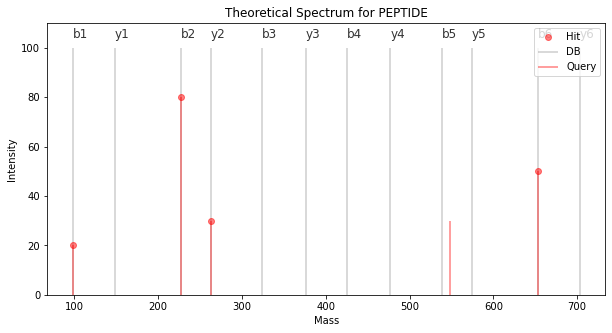

In [ ]:
import matplotlib.pyplot as plt
from alphapept import constants
from alphapept.fasta import get_frag_dict, parse
import alphapept.io
import numpy as np

%matplotlib inline
peptide = 'PEPTIDE'

# Theoretical Spectrum

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)
db_frag = list(frag_dict.values())
db_frag.sort()

db_int = [100 for _ in db_frag]

# Experimental Spectrum, dummy data

query_frag = np.array([98.06, 227.10, 263.08, 548.06, 653.31])
query_int = np.array([20, 80, 30, 30, 50])

hits = compare_frags(query_frag, db_frag, mtol=1)

hitpos = hits[hits > 0] - 1
hit_x = query_frag[hitpos]
hit_y = query_int[hitpos]


plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)
plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.ylim([0,110])
plt.show()

## Comparing Spectra

To compare multiple spectra against a database, we first need some helper functions. Per default, AlphaPept calculates in Dalton. To use ppm boundaries, we need the function `ppm_to_dalton` for conversion. 

To minimize the search space, we typically only compare spectra with precursors in the same mass range as defined by `m_offset`. To look up the limits for search, we define the function `get_idxs`, which is a wrapper to the fast `searchsorted` method from NumPy.

The actual search takes place in `compare_specs_single` and `compare_specs_parallel`, a single-core and multicore method for comparing spectra.

In [ ]:
#export
from numba import prange
@njit
def ppm_to_dalton(mass, m_offset):
    """

    """
    return mass / 1e6 * m_offset


def get_idxs(db_masses, query_masses, m_offset, ppm):
    """
    Function to get upper and lower limits to define search range.

    """
    if ppm:
        dalton_offset = ppm_to_dalton(query_masses, m_offset)
    else:
        dalton_offset = m_offset

    idxs_lower = db_masses.searchsorted(query_masses - dalton_offset, side="left")
    idxs_higher = db_masses.searchsorted(query_masses + dalton_offset, side="right")

    return idxs_lower, idxs_higher

@njit(parallel=True)
def compare_specs_parallel(
    frag_hits,
    query_masses,
    query_frags,
    query_indices,
    db_masses,
    db_frags,
    idxs_lower,
    idxs_higher,
    mtol,
    query_bounds,
    db_bounds,
    chunk=(0, 1),
    offset=False,
    ppm=False,
):
    """
    Compare spectra, parallelized version
    """
    num_specs_compared = 0
    if chunk == (0, 0):
        for query_idx in prange(len(query_masses)):
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_idx_start = query_indices[query_idx]
                query_idx_end = query_indices[query_idx + 1]
                query_frag = query_frags[query_idx_start:query_idx_end]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)
    else:
        # Chunked version
        current_index = chunk[0]
        n_chunks = chunk[1]
        m_subset = np.arange(len(query_masses))[current_index::n_chunks]

        for index in prange(len(m_subset)):
            query_idx = m_subset[index]
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_idx_start = query_indices[query_idx]
                query_idx_end = query_indices[query_idx + 1]
                query_frag = query_frags[query_idx_start:query_idx_end]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)

    return frag_hits, num_specs_compared


@njit
def compare_specs_single(
    frag_hits,
    query_masses,
    query_frags,
    query_indices,
    db_masses,
    db_frags,
    idxs_lower,
    idxs_higher,
    mtol,
    query_bounds,
    db_bounds,
    chunk=(0, 1),
    offset=False,
    ppm=False,
):
    """
    Compare spectra, single core version

    """
    num_specs_compared = 0

    if chunk == (0, 0):
        for query_idx in range(len(query_masses)):
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_idx_start = query_indices[query_idx]
                query_idx_end = query_indices[query_idx + 1]
                query_frag = query_frags[query_idx_start:query_idx_end]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)
    else:
        # Chunked version
        current_index = chunk[0]
        n_chunks = chunk[1]

        m_subset = np.arange(len(query_masses))[current_index::n_chunks]

        for index in range(len(m_subset)):
            query_idx = m_subset[index]
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_idx_start = query_indices[query_idx]
                query_idx_end = query_indices[query_idx + 1]
                query_frag = query_frags[query_idx_start:query_idx_end]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)

    return frag_hits, num_specs_compared

## Wrapper

In [ ]:
#export

import pandas as pd
import logging

def query_data_to_features(query_data):

    # if we dont use the feature finder we extract them from the query data..

    query_masses = query_data['prec_mass_list2']
    query_mz = query_data['mono_mzs2']
    query_rt = query_data['rt_list_ms2']

    features = pd.DataFrame(np.array([query_masses, query_mz, query_rt]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched'])

    features['feature_idx'] = features.index #Index to query_data
    features['query_idx']  = np.arange(len(query_masses))

    features = features.sort_values('mass_matched', ascending=True)

    return features

def get_psms(
    query_data,
    db_data,
    features,
    parallel,
    m_tol,
    m_offset,
    ppm,
    min_frag_hits,
    callback = None,
    m_offset_calibrated = None,
    **kwargs
):
    """
    Wrapper function to extract psms from dataset

    Args:
        db_masses: database precursor masses
        query_masses: query precursor masses
        m_offset: mass offset in dalton or ppm
        ppm: flag for ppm or dalton
        callback: Callback function, e.g. for progress bar
    Returns:
        idxs_lower: lower search range
        idxs_higher: upper search range
    Raises:
    """


    db_masses = db_data['precursors']
    db_frags = db_data['fragmasses']
    db_bounds = db_data['bounds']
    
    query_indices = query_data["indices_ms2"]
    query_bounds = query_data['bounds']
    query_frags = query_data['mass_list_ms2']

    if features is not None:
        if m_offset_calibrated:
            m_offset = m_offset_calibrated
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_bounds = query_bounds[features['query_idx'].values]
        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        if m_offset_calibrated:
            m_offset = m_offset_calibrated
        query_masses = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']
    
#     idxs_lower, idxs_higher = get_idxs(db_masses, query_masses, m_offset, ppm)
    idxs_lower, idxs_higher = get_idxs(
        db_masses,
        query_masses,
        m_offset,
        ppm
    )
    frag_hits = np.zeros(
        (len(query_masses), np.max(idxs_higher - idxs_lower)), dtype=int
    )

    logging.info('Performing search on {:,} query and {:,} db entries with m_tol = {} and m_offset = {}.'.format(len(query_masses), len(db_masses), m_tol, m_offset))

    if callback is None:
        chunk = (0, 0)
        offset = False

        if parallel:
            frag_hits, num_specs_compared = compare_specs_parallel(
                frag_hits,
                query_masses,
                query_frags,
                query_indices,
                db_masses,
                db_frags,
                idxs_lower,
                idxs_higher,
                m_tol,
                query_bounds,
                db_bounds,
                chunk,
                offset,
                ppm,
            )
        else:
            frag_hits, num_specs_compared = compare_specs_single(
                frag_hits,
                query_masses,
                query_frags,
                query_indices,
                db_masses,
                db_frags,
                idxs_lower,
                idxs_higher,
                m_tol,
                query_bounds,
                db_bounds,
                chunk,
                offset,
                ppm,
            )

    else: #chunk the data for progess bar until numba has proper progress bar
        n_chunks = 100
        num_specs_compared = 0

        for current_chunk in range(n_chunks):
            chunk = (current_chunk, n_chunks)
            offset = False
            if parallel:
                frag_hits, num_specs_compared_chunk = compare_specs_parallel(
                    frag_hits,
                    query_masses,
                    query_frags,
                    query_indices,
                    db_masses,
                    db_frags,
                    idxs_lower,
                    idxs_higher,
                    m_tol,
                    query_bounds,
                    db_bounds,
                    chunk,
                    offset,
                    ppm,
                )
            else:
                frag_hits, num_specs_compared_chunk = compare_specs_single(
                    frag_hits,
                    query_masses,
                    query_frags,
                    query_indices,
                    db_masses,
                    db_frags,
                    idxs_lower,
                    idxs_higher,
                    m_tol,
                    query_bounds,
                    db_bounds,
                    chunk,
                    offset,
                    ppm,
                )

            if callback is not None:
                callback((current_chunk+1)/n_chunks)
            num_specs_compared += num_specs_compared_chunk

    hit_query, hit_db = np.where(frag_hits >= min_frag_hits)
    hits = frag_hits[hit_query, hit_db]
    hit_db += idxs_lower[hit_query]

    psms = np.array(
        list(zip(hit_query, hit_db, hits)), dtype=[("query_idx", int), ("db_idx", int), ("hits", int)]
    )

    logging.info('Compared {:,} spectra and found {:,} psms.'.format(num_specs_compared, len(psms)))

    return psms, num_specs_compared

## Extracting columns for scoring

### Frag Delta

In [ ]:
#export
@njit
def frag_delta(query_frag, db_frag, hits):
    """
    Calculate the mass difference for a given array of hits in Dalton and ppm
    """

    delta_m = db_frag[hits > 0] - query_frag[hits[hits > 0] - 1]
    delta_m_ppm = (
        2 * delta_m / (db_frag[hits > 0] + query_frag[hits[hits > 0] - 1]) * 1e6
    )

    return delta_m, delta_m_ppm

In [ ]:
#hide
def test_frag_delta():
    mtol = 10
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([101, 202, 303, 404])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    delta_m, delta_m_ppm = frag_delta(query_frag, db_frag, hits)

    assert np.sum(delta_m) == 10
    
test_frag_delta()

### Intensity Fraction

In [ ]:
#export
@njit
def intensity_fraction(query_int, hits):
    """
    Calculate the fraction of matched intensity
    """
    total_intensity = np.sum(query_int)
    if total_intensity != 0:
        matched_intensity = np.sum(query_int[hits[hits > 0] - 1])
        i_frac = matched_intensity / total_intensity
    else:
        i_frac = 0

    return i_frac

In [ ]:
#hide
def test_intensity_fraction():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    i_frac = intensity_fraction(query_int, hits)

    assert i_frac == 40 / 100

test_intensity_fraction()

### Intensity Product

In [ ]:
#export
@njit
def intensity_product(query_int, hits, db_int=None):
    """
    Calculate the dot product of matched query intensity to db intensity
    """

    matched_query_int = query_int[hits[hits > 0] - 1]
    if db_int is None:
        matched_intensity = np.sum(matched_query_int)
    else:
        matched_db_int = db_int[hits > 0]
        matched_intensity = np.sum(matched_query_int*matched_db_int)

    return matched_intensity

In [ ]:
#hide
def test_intensity_product():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits) == 40

    query_frag = np.array([100, 200, 300, 400, 600])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40, 50])
    db_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits, db_int = db_int) == 10*10+30*20
    
test_intensity_product()

### Mass density scores

The following functions are used to calculate scores that take the relative abundance of fragment ion masses in the database into account. The underlying hypothesis is that matched ions in less populated m/z regions are worth more that ions matched in highly populated m/z regions. 

The `get_frag_mass_density_norm` takes fragment ion masses `frags` as input and creates both an array of m/z bins and the respective negaive m/z density values. The `mz_factor` determines the m/z bin-width. A factor of 0.5 results in m/z bins of 20 Da, while a factor of 10 results in m/z bins of 0.1 Da. 

The score calculated by `mass_density_weighted_fragment_sum` corresponds to the sum of fragment ion hits weighted by the negative mass density. A fragment ion match in a sparsely populated m/z region therefor counts nearly 1, while a match in a densely populated region contributes with a low weight, e.g. 0.1.

The score calculated by `mass_density_weighted_intensity_sum` corresponds to a matched intensity score weighted by the negative mass density.

In [ ]:
#export 
@njit
def get_frag_mass_density_norm(frags, mz_factor=0.05):
    frags_f = frags.flatten()
    frags_f_p = frags_f[frags_f >= 0]
    frags_f_p = (frags_f_p*mz_factor).astype(np.int64)
    mz_space = np.arange(0,np.max(frags_f_p)+1,1)/mz_factor
    mz_count = np.bincount(frags_f_p)

    if np.percentile(mz_count,90) > 0:
        if np.max(mz_count)/np.percentile(mz_count,90) > 50:
            mz_count_norm = np.zeros(len(mz_count))
            for i in prange(len(mz_count)):
                if mz_count[i] > 0:
                    mz_count_norm[i] = np.log(mz_count[i])
                else:
                    mz_count_norm[i] = 0
            max_int = np.max(mz_count_norm)
            mz_count_norm = mz_count_norm/max_int
        else:
            max_int = np.max(mz_count)
            mz_count_norm = mz_count/max_int
    else:
        max_int = np.max(mz_count)
        mz_count_norm = mz_count/max_int

    percentile_range = np.arange(0,0.9,0.1)
    mz_percentiles = np.searchsorted(percentile_range, mz_count_norm, side='left')

    neg_mz_density = np.zeros(len(mz_space))
    for i in prange(len(mz_space)):
        neg_mz_density[i] = (10-mz_percentiles[i])/10

    return neg_mz_density, mz_space

@njit
def mass_density_weighted_fragment_sum(query_frag, hits, mz_space, mz_density, mz_factor=0.05):
    matched_query_frag = query_frag[hits[hits > 0]-1]
    matched_query_frag_bin = (matched_query_frag*mz_factor).astype(np.int64)

    matched_query_frag_density = np.zeros(len(matched_query_frag_bin))
    for i in prange(len(matched_query_frag_bin)):
        matched_query_frag_density[i] = mz_density[matched_query_frag_bin[i]]
    return np.sum(matched_query_frag_density)

@njit
def mass_density_weighted_intensity_sum(query_int, query_frag, hits, mz_space, mz_density, mz_factor=0.05):
    matched_query_frag = query_frag[hits[hits > 0]-1]
    matched_query_frag_bin = (matched_query_frag*mz_factor).astype(np.int64)

    matched_query_frag_density = np.zeros(len(matched_query_frag_bin))
    for i in prange(len(matched_query_frag_bin)):
        matched_query_frag_density[i] = mz_density[matched_query_frag_bin[i]]

    matched_query_int = query_int[hits[hits > 0] - 1]

    if len(matched_query_frag_density) > 0:
        weighted_intensity_sum = np.sum(matched_query_int*matched_query_frag_density)
        if weighted_intensity_sum!=0:
            weighted_intensity_sum = np.log(weighted_intensity_sum)
        else:
            weighted_intensity_sum = 0
    else:
        weighted_intensity_sum = 0

    return weighted_intensity_sum

In [ ]:
#hide
def test_get_frag_mass_density_norm():
    db_frags = np.array([-1, 10, 20, 100, 110, -1])

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert len(mz_space) == 6
    assert mz_space[0] == 0
    assert all(neg_mz_density == np.array([0.5, 0.5, 1. , 1. , 1. , 0.1]))

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=10)
    assert len(mz_space) == 1101
    assert mz_space[0] == 0
    assert all(neg_mz_density[0:5] == np.array([1., 1., 1., 1., 1.]))
    assert neg_mz_density[100] == 0.1

test_get_frag_mass_density_norm()
    
def test_mass_density_weighted_fragment_sum():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    db_frags = np.array([-1, 100, 200, 300, 400, -1])
    
    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert mass_density_weighted_fragment_sum(query_frag, hits, mz_space, neg_mz_density, mz_factor=0.05) == 0.2

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=10)
    assert np.round(mass_density_weighted_fragment_sum(query_frag, hits, mz_space, neg_mz_density, mz_factor=10), decimals=3) == 0.2

test_mass_density_weighted_fragment_sum()

def test_mass_density_weighted_intensity_sum():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    db_frags = np.array([-1, 100, 200, 300, 400, -1])
    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert np.round(mass_density_weighted_intensity_sum(query_int, query_frag, hits, mz_space, neg_mz_density, mz_factor=0.05), decimals=3) == 1.386
    
test_mass_density_weighted_intensity_sum()


### B & Y - Hits

In [ ]:
#export
@njit
def b_y_hits(frag_type, hits):
    """
    Count the number of b and y hits
    hits usually start with b-ions > 0, then y-ions < 1
    """
    hits_index = hits > 0

    hit_types = frag_type[hits_index]

    b_hits = np.sum(hit_types > 0)
    y_hits = np.sum(hit_types < 0)

    return b_hits, y_hits

In [ ]:
#hide
def test_b_y_hits():
    # TODO: Write a test to make sure the by hits are correct..
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])
    frag_type = np.array([1, -1, 2, -2])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 1
    assert (y_hit) == 1

    frag_type = np.array([-1, -2, -3, -4])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)
    
    assert (b_hit) == 0
    assert (y_hit) == 2

    frag_type = np.array([1, 2, 3, 4])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 2
    assert (y_hit) == 0
    
test_b_y_hits()

In [ ]:
### Extracting Score columns

In [ ]:
#export
from numpy.lib.recfunctions import append_fields, drop_fields


def add_column(recarray, column, name):
    """
    Function to add a column with given name to recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    recarray = append_fields(
        recarray, name, column, dtypes=column.dtype, usemask=False, asrecarray=True
    )
    return recarray


def remove_column(recarray, name):
    """
    Function to remove a column from recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    return recarray

## Reporting

When performing a database search, we need to know what experimental spectrum we are comparing with which database entry. 
We distinguish three indices:
* query_idx
* raw_idx
* feature_idx
Initially, the get_psms functions accepts experimental data in the form of `query_data`. Here, the `query_idx` refers to the index to `query_data`. However, this might not be the same index as of the raw data. This is due to the implementation of the matching of MS1-features to MS2 spectra. Here we allow multiple matches and implement this by repeating the respective spectra. 

We then add the two columns `feature_idx` and `raw_idx` to the psms to later be able to distinguish where the match originated from. Here, `raw_idx` refers to the original spectrum.

When not applying feature finding, `raw_idx` and `query_idx` are equivalent.

In [ ]:
#export
from numba.typed import List
@njit
def get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, losses):
    
    max_array_size = len(db_frag)*len(losses)

    ions = np.zeros((max_array_size, 8))

    pointer = 0
    
    query_range = np.arange(len(query_frag))
    db_range = np.arange(len(db_frag))

    for idx, off in enumerate(losses):
        hits = compare_frags(query_frag, db_frag-off, mtol, ppm)
        n_hits = np.sum(hits>0)
        
        hitpos = hits[hits > 0] - 1
        hit = hits > 0
        
        ions[pointer:pointer+n_hits,0] = frag_type[hits>0] #type
        ions[pointer:pointer+n_hits,1] = idx #ion-index
        
        ions[pointer:pointer+n_hits,2] = query_int[hitpos] #query int
        ions[pointer:pointer+n_hits,3] = db_int[hit] #db int
        
        ions[pointer:pointer+n_hits,4] = query_frag[hitpos] #query mass
        ions[pointer:pointer+n_hits,5] = db_frag[hit]-off # db mass  
        
        ions[pointer:pointer+n_hits,6] = query_range[hitpos] # index to db entry
        ions[pointer:pointer+n_hits,7] = db_range[hit] # index to query entry
    
        pointer += n_hits

    ions = ions[:pointer,:]
        
    return ions

@njit
def score(
    psms,
    query_masses,
    query_frags,
    query_ints,
    query_indices,
    db_masses,
    db_frags,
    frag_types,
    mtol,
    query_bounds,
    db_bounds,
    ppm,
    psms_dtype,
    db_ints = None,
    parallel = False
):

    psms_ = np.zeros(len(psms), dtype=psms_dtype)  
    
    losses = [0, 18.01056468346, 17.03052] #H2O, NH3
    
    ions_ = List()
    
    ion_count = 0
    
    for i in range(len(psms)):
        query_idx = psms[i]["query_idx"]
        db_idx = psms[i]["db_idx"]
        query_idx_start = query_indices[query_idx]
        query_idx_end = query_indices[query_idx + 1]
        query_frag = query_frags[query_idx_start:query_idx_end]
        query_int = query_ints[query_idx_start:query_idx_end]
        db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
        frag_type = frag_types[:, db_idx] [: db_bounds[db_idx] ]

        if db_ints is None:
            db_int = np.zeros(len(db_frag))
        else:
            db_int = db_ints[i]

        ions = get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, losses)

        psms_['o_mass'][i] = query_masses[query_idx] - db_masses[db_idx]
        psms_['o_mass_ppm'][i] = 2 * psms_['o_mass'][i] / (query_masses[query_idx]  + db_masses[db_idx] ) * 1e6

        psms_['delta_m'][i] = np.mean(ions[:,4]-ions[:,5])
        psms_['delta_m_ppm'][i] = np.mean(2 * psms_['delta_m'][i] / (ions[:,4]  + ions[:,5] ) * 1e6)

        psms_['total_int'][i] = np.sum(query_int)
        psms_['matched_int'][i] = np.sum(ions[:,2])
        psms_['matched_int_ratio'][i] = psms_['matched_int'][i] / psms_['total_int'][i]
        psms_['int_ratio'][i] = np.mean(ions[:,3]/ions[:,2])
        
        psms_['b_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]>0)
        psms_['y_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]<0)
        
        psms_['b-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]>0)
        psms_['y-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]<0)
        
        psms_['b-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]>0)
        psms_['y-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]<0)
        
        n_ions = len(ions)
        
        psms_['n_ions'][i] = n_ions
        psms_['ion_idx'][i] = ion_count
        
        ion_count += n_ions
        ions_.append(ions)
        
    return psms_, ions_


In [ ]:
#export

from numba.typed import Dict
def get_sequences(psms, db_seqs):
    """
    Get sequences to add them to a recarray
    """
    sequence_list = db_seqs[psms["db_idx"]]

    return sequence_list


def get_score_columns(
    psms,
    query_data,
    db_data,
    features,
    parallel,
    m_tol,
    m_offset,
    ppm,
    m_offset_calibrated=None,
    **kwargs
):
    logging.info('Extracting columns for scoring.')
    query_indices = query_data["indices_ms2"]
    query_bounds = query_data['bounds']
    query_charges = query_data['charge2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    db_masses = db_data['precursors']
    db_frags = db_data['fragmasses']
    db_bounds = db_data['bounds']
    frag_types = db_data['fragtypes']

    db_seqs = db_data['seqs']

    if 'db_ints' in db_data.keys():
        db_ints = db_data['db_ints']
    else:
        db_ints = None

    if features is not None:
        if m_offset_calibrated:
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_bounds = query_bounds[features['query_idx'].values]
        query_charges = query_charges[features['query_idx'].values]
        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_ints = np.concatenate(
            [
                query_ints[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        query_masses = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']
        

    loss_dict = Dict()
    loss_dict[''] = 0.0
    loss_dict['-H2O'] = 18.01056468346
    loss_dict['-NH3'] = 17.03052

    float_fields = ['o_mass', 'o_mass_ppm','delta_m','delta_m_ppm','matched_int_ratio','int_ratio']
    int_fields = ['total_int','matched_int','n_ions','ion_idx'] + [a+_+'_hits' for _ in loss_dict for a in ['b','y']] 

    psms_dtype = np.dtype([(_,np.float32) for _ in float_fields] + [(_,np.int64) for _ in int_fields])

    psms_, ions_,  = score(
        psms,
        query_masses,
        query_frags,
        query_ints,
        query_indices,
        db_masses,
        db_frags,
        frag_types,
        m_tol,
        query_bounds,
        db_bounds,
        ppm,
        psms_dtype)
    
    ions_ = np.vstack(ions_)

    for _ in psms_.dtype.names:
        psms = add_column(psms, psms_[_], _)
        
    rts = np.array(query_rt)[psms["query_idx"]]
    psms = add_column(psms, rts, 'rt')

    seqs = get_sequences(psms, db_seqs)
    psms = add_column(psms, seqs, "sequence")

    mass = np.array(query_masses)[psms["query_idx"]]
    mz = np.array(query_mz)[psms["query_idx"]]
    charge = np.array(query_charges)[psms["query_idx"]]

    psms = add_column(psms, mass, "mass")
    psms = add_column(psms, mz, "mz")
    psms = add_column(psms, charge, "charge")
    
    psms = add_column(psms, np.char.add(np.char.add(psms['sequence'],"_"), psms['charge'].astype(int).astype(str)), 'precursor')

    if features is not None:
        psms = add_column(psms, features.loc[psms['query_idx']]['feature_idx'].values, 'feature_idx')
        psms = add_column(psms, features.loc[psms['query_idx']]['query_idx'].values, 'raw_idx')
        
        for key in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm','dist','mobility']:
            if key in features.keys():
                psms = add_column(psms, features.loc[psms['query_idx']][key].values, key)

    logging.info(f'Extracted columns from {len(psms):,} spectra.')

    return psms, ions_

## Plot

In [ ]:
#export

def plot_hit(
    df,
    index,
    db_bounds,
    db_frags,
    frag_types,
    query_bounds,
    query_frags,
    query_ints,
    query_indices,
    ppm,
    m_tol,
    db_ints = None,
    **kwargs
):
    spectrum = df.iloc[index]

    sequence = spectrum["sequence"]

    db_idx = spectrum["db_idx"]
    query_idx = spectrum["query_idx"]

    intensity_fraction = spectrum["matched_int"] / spectrum["total_int"]

    db_bound = db_bounds[db_idx]
    db_frag = db_frags[:, db_idx] [:db_bound]
    if db_ints is not None:
        db_int = db_ints[:, db_idx] [:db_bound]
    else:
        db_int = np.ones(len(db_frag))

    db_int = db_int / np.max(db_int) * 100

    frag_type = frag_types[:, db_idx] [:db_bound]

    query_bound = query_bounds[query_idx]
    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int = query_int / np.max(query_int) * 100

    hits = compare_frags(query_frag, db_frag, m_tol, ppm)

    n_hits = np.sum(hits > 0)

    hitpos = hits[hits > 0] - 1

    hit_x = query_frag[hitpos]
    hit_y = query_int[hitpos]

    # create an axis
    ax = plt.figure(figsize=(10, 5))

    plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

    plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

    plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

    figure_title = "PSM Match for Spectra: {} - sequence {} \nHits {} - Intensity Fraction {:.2f} %".format(
        query_idx, sequence, n_hits, intensity_fraction * 100
    )
    plt.title(figure_title)

    plt.xlabel("Mass")
    plt.ylabel("Relative Intensity (%)")
    plt.ylim([0, 110])

    plt.legend()
    plt.show()

from alphapept.fasta import get_frag_dict, parse
import matplotlib.pyplot as plt

def plot_psms(query_data, df, index, mass_dict, ppm=True, m_tol=20):
    """
    Plot a psms
    """
    spectrum = df.iloc[index]

    sequence = spectrum["sequence"]
    db_idx = spectrum["db_idx"]
    query_idx = spectrum["query_idx"]

    if 'matched_int' in spectrum.index:
        intensity_fraction = spectrum["matched_int"] / spectrum["total_int"]
    else:
        intensity_fraction = np.nan
        matched_int = np.nan

    frag_dict = get_frag_dict(parse(sequence), mass_dict)
    frag_dict_r = {v: k for k, v in frag_dict.items()}

    db_frag = list(frag_dict.values())
    db_frag.sort()

    db_int = [100 for _ in db_frag]

    query_bounds = query_data['bounds']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    query_bound = query_bounds[query_idx]
    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int = query_int / np.max(query_int) * 100

    hits = compare_frags(query_frag, db_frag, m_tol, ppm)

    n_hits = np.sum(hits > 0)

    hitpos = hits[hits > 0] - 1

    hit_x = query_frag[hitpos]
    hit_y = query_int[hitpos]

    # create an axis
    ax = plt.figure(figsize=(10, 5))

    plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

    plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

    plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

    figure_title = "Peptide-Spectrum-Match for Spectra: {} - sequence {} \nHits {} - Intensity Fraction {:.2f} %".format(
        query_idx, sequence, n_hits, intensity_fraction * 100
    )

    db_hits = np.array(db_frag)[hits>0]
    ion_hits = [frag_dict_r[_] for _ in db_hits]

    for _ in frag_dict.keys():

        if _ in ion_hits:
            color = 'r'
        else:
            color = 'k'

        if _[0] == 'y':
            plt.text(frag_dict[_], 110, _, fontsize=12, alpha = 0.8, color=color)
        else:
            plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8, color=color)

    plt.title(figure_title)

    plt.xlabel("Mass")
    plt.ylabel("Relative Intensity (%)")
    plt.ylim([0, 120])

    plt.legend(loc='lower right')
    plt.show()

## Wrapper

In [ ]:
#export
def perform_search(query_files, db_masses, db_frags, db_bounds, db_seqs, frag_types, plot, **kwargs):
    """
    Function to search and score one or multiple MS runs by the X!Tandem approach.

    """
    if isinstance(query_files, str):
        kwargs['query_path'] = query_files
        psms_all = score_psms(db_masses, db_frags, db_bounds, db_seqs, frag_types, plot=plot, **kwargs)
        psms_all['filename'] = query_files
    elif isinstance(query_files, list):
        psms_all = []
        for file in query_files:
            kwargs['query_path'] = file
            psms = score_psms(db_masses, db_frags, db_bounds, db_seqs, frag_types, plot=plot, **kwargs)
            psms['filename'] = file
            psms_all.append(psms)
        psms_all = pd.concat(psms_all, ignore_index=True)
    else:
        raise Exception('query_files should be either a string or a list. The selected query_files argument is of type: {}'.format(type(query_files)))
    return psms_all

## Searching with database

We save intermediate results to hdf5 files

In [ ]:
#export
import os
import pandas as pd
import copy
import alphapept.io
import alphapept.fasta

def store_hdf(df, path, key, replace=False, swmr = False):
    """
    Stores in hdf
    """
    ms_file = alphapept.io.MS_Data_File(path.file_name, is_overwritable=True)
    
    if replace:
        ms_file.write(df, dataset_name=key)
    else:
        try:
            df.to_hdf(path, key=key, append=True)
            #TODO, append is not implemented yet
        except (ValueError, AttributeError):
            try:
                old_df = ms_file.read(dataset_name=key, swmr = swmr)
                new_df = pd.concat([old_df, df])
                ms_file.write(new_df, dataset_name=key, swmr = swmr)
            except KeyError:
                ms_file.write(df, dataset_name=key, swmr= swmr)

def search_db(to_process):
    """
    Perform a databse search. One file at a time.
    """

    ms_file, settings = to_process

    skip = False
    feature_calibration = False

    if 'm_offset_calibrated' in settings["search"]:
        calibration = settings['search']['m_offset_calibrated']
        logging.info('Found calibrated m_offset with value {}'.format(calibration))
        feature_calibration = True
        if calibration == 0:
            logging.info('Calibration is 0, skipping second database search.')
            skip = True

    if not skip:
        db_data = alphapept.fasta.read_database(
            settings['fasta']['database_path']
        )


        ms_file = alphapept.io.MS_Data_File(
            f"{ms_file}"
        )

    
#         TODO calibrated_fragments should be included in settings
        query_data = ms_file.read_DDA_query_data(
            calibrated_fragments=True,
            database_file_name=settings['fasta']['database_path']
        )

        features = ms_file.read(dataset_name="features")

        psms, num_specs_compared = get_psms(query_data, db_data, features, **settings["search"])
        if len(psms) > 0:
            psms, ions = get_score_columns(psms, query_data, db_data, features, **settings["search"])

        if 'm_offset_calibrated' in settings["search"]:
            logging.info('Saving second_search results to {}'.format(ms_file))
            save_field = 'second_search'
        else:
            logging.info('Saving first_search results to {}'.format(ms_file))
            save_field = 'first_search'
        
        store_hdf(pd.DataFrame(psms), ms_file, save_field, replace=True)
        ion_columns = ['ion_index','ion_type','ion_int','db_int','ion_mass','db_mass','query_idx','db_idx']
        store_hdf(pd.DataFrame(ions, columns = ion_columns), ms_file, 'ions', replace=True)


def search_parallel_db(settings, calibration = None, callback = None):
    """
    Function to generate a database from a fasta file
    """
    ms_files = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        ms_files.append(base + '.ms_data.hdf')

    if calibration:
        custom_settings = []
        for _ in calibration:
            settings_ = copy.deepcopy(settings)
            settings_["search"]["m_offset_calibrated"] = _
            custom_settings.append(settings_)
    else:
        custom_settings = [settings for _ in ms_files]

    n_processes = settings['general']['n_processes']

    to_process = [(ms_files[i], custom_settings[i]) for i in range(len(ms_files))]

    if len(to_process) == 1:
        ms_file, settings_ = to_process[0]
        settings_['search']['parallel'] = True
        search_db((ms_file, settings_))
    else:
        with Pool(n_processes) as p:
            max_ = len(to_process)
            for i, _ in enumerate(p.imap_unordered(search_db, to_process)):
                if callback:
                    callback((i+1)/max_)

    db_data = alphapept.fasta.read_database(
        settings['fasta']['database_path']
    )

    return db_data['fasta_dict'].item(), db_data['pept_dict'].item()

## Searching Large Fasta and or Search Space

In [ ]:
#export

from alphapept.fasta import blocks, generate_peptides, add_to_pept_dict
from alphapept.io import list_to_numpy_f32
from alphapept.fasta import block_idx, generate_fasta_list, generate_spectra, check_peptide
from alphapept import constants
mass_dict = constants.mass_dict

def search_fasta_block(to_process):
    """
    Search fasta block
    For searches with big fasta files or unspecific searches
    """

    fasta_index, fasta_block, ms_files, settings = to_process

    settings_ = settings[0]
    spectra_block = settings_['fasta']['spectra_block']
    to_add = List()

    psms_container = [list() for _ in ms_files]

    f_index = 0

    pept_dict = {}
    for element in fasta_block:
        sequence = element["sequence"]
        mod_peptides = generate_peptides(sequence, **settings_['fasta'])

        pept_dict, added_peptides = add_to_pept_dict(pept_dict, mod_peptides, fasta_index+f_index)

        if len(added_peptides) > 0:
            to_add.extend(added_peptides)
        f_index += 1

    if len(to_add) > 0:
        for seq_block in blocks(to_add, spectra_block):
            spectra = generate_spectra(seq_block, mass_dict)
            precmasses, seqs, fragmasses, fragtypes = zip(*spectra)
            sortindex = np.argsort(precmasses)

            db_data = {}
            db_data['precursors'] = np.array(precmasses)[sortindex]
            db_data['seqs'] = np.array(seqs)[sortindex]
            db_data['fragmasses']  = list_to_numpy_f32(np.array(fragmasses, dtype=object)[sortindex])
            db_data['fragtypes'] = list_to_numpy_f32(np.array(fragtypes, dtype=object)[sortindex])
            db_data['bounds'] = np.sum(db_data['fragmasses']>=0,axis=0).astype(np.int64)

            for file_idx, ms_file in enumerate(ms_files):
                query_data = alphapept.io.MS_Data_File(
                    f"{ms_file}"
                ).read_DDA_query_data(swmr=True)

                try:
                    features = alphapept.io.MS_Data_File(
                        ms_file
                    ).read(dataset_name="features",swmr=True)
                except FileNotFoundError:
                    features = None
                except KeyError:
                    features = None
        
                psms, num_specs_compared = get_psms(query_data, db_data, features, **settings[file_idx]["search"])

                if len(psms) > 0:
                    psms, ions = get_score_columns(psms, query_data, db_data, features, **settings[file_idx]["search"])

                    fasta_indices = [','.join([str(x) for x in pept_dict[_]]) for _ in psms['sequence']]

                    psms_df = pd.DataFrame(psms)
                    psms_df['fasta_index'] = fasta_indices

                    psms_container[file_idx].append(psms_df)

    return psms_container, len(to_add)

from multiprocessing import Pool


def search_parallel(settings, calibration = None, callback = None):
    """
    Function to generate a database from a fasta file
    """
    fasta_list, fasta_dict = generate_fasta_list(**settings['fasta'])

    fasta_block = settings['fasta']['fasta_block']

    ms_file_path = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        ms_file_path.append(base + '.ms_data.hdf')

    if calibration:
        custom_settings = []
        for _ in calibration:
            settings_ = copy.deepcopy(settings)
            settings_["search"]["m_offset_calibrated"] = _
            custom_settings.append(settings_)
    else:
        custom_settings = [settings for _ in ms_file_path]
    
    
    logging.info(f"Number of FASTA entries: {len(fasta_list):,} - FASTA settings {settings['fasta']}")
    to_process = [(idx_start, fasta_list[idx_start:idx_end], ms_file_path, custom_settings) for idx_start, idx_end in block_idx(len(fasta_list), fasta_block)]

    n_processes = settings['general']['n_processes']

    n_seqs_ = 0
    with Pool(n_processes) as p:
        max_ = len(to_process)
        
        for i, (_, n_seqs) in enumerate(p.imap_unordered(search_fasta_block, to_process)):
            n_seqs_ += n_seqs
            logging.info(f'Block {i+1} of {max_} complete - {(i+1)/max_*100:.2f} % - created peptides {n_seqs:,}')
            for j in range(len(_)):
                ms_file = alphapept.io.MS_Data_File(ms_file_path[j])
                output = [_ for _ in _[j]]
                if len(output) > 0:
                    if calibration:
                        store_hdf(pd.concat(output), ms_file, 'second_search', swmr = True)
                    else:
                        store_hdf(pd.concat(output), ms_file, 'first_search', swmr = True)

            if callback:
                callback((i+1)/max_)
    
    logging.info(f'Complete. Created peptides {n_seqs_:,}')
    
    return fasta_dict

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted index.ipynb.
Converted ML_Test.ipynb.
Converted Untitled.ipynb.
